In [ ]:
!pip install cupy-cuda12x

In [ ]:
!nvidia-smi

Thu May 22 17:28:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import cupy as cp
import numpy as np
import scipy.fft
import concurrent.futures

def levy_stable_gpu(alpha: float, beta: float, size: int, mu: float = 0.0, sigma: float = 1.0) -> cp.ndarray:
    if alpha == 2:
        return mu + cp.random.standard_normal(size) * cp.sqrt(2.0) * sigma

    radius = 1e-15
    if cp.absolute(alpha - 1.0) < radius:
        alpha = 1.0 + radius

    r1 = cp.random.random(size)
    r2 = cp.random.random(size)
    pi = cp.pi

    a = 1.0 - alpha
    b = r1 - 0.5
    c = a * b * pi
    e = beta * cp.tan(cp.pi * alpha / 2.0)
    f = (-(cp.cos(c) + e * cp.sin(c)) / (cp.log(r2) * cp.cos(b * pi))) ** (a / alpha)
    g = cp.tan(cp.pi * b / 2.0)
    h = cp.tan(c / 2.0)
    i = 1.0 - g ** 2.0
    j = f * (2.0 * (g - h) * (g * h + 1.0) - (h * i - 2.0 * g) * e * 2.0 * h)
    k = j / (i * (h ** 2.0 + 1.0)) + e * (f - 1.0)

    return mu + sigma * k


def truncated_levy_stable_gpu(trunc: float, alpha: float, beta: float, size: int, mu: float = 0.0,
                               sigma: float = 1.0) -> cp.ndarray:
    z = levy_stable_gpu(alpha=alpha, beta=beta, mu=mu, sigma=sigma, size=size)

    too_big = cp.where(cp.abs(z) > trunc)[0]

    while too_big.size > 0:
        z[too_big] = levy_stable_gpu(alpha=alpha, beta=beta, mu=mu, sigma=sigma, size=too_big.size)
        too_big_remaining = cp.where(cp.abs(z[too_big]) > trunc)[0]
        too_big = too_big[too_big_remaining]

    return z


def memory_efficient_truncated_levy_stable_gpu(trunc: float, alpha: float, beta: float, size: int,
                                               mu: float = 0.0, sigma: float = 1.0, steps: int = 256) -> cp.ndarray:
    step_length = size // steps
    remaining = size % steps

    out = cp.zeros(size)
    for i in range(steps):
        out[i * step_length:(i + 1) * step_length] = truncated_levy_stable_gpu(trunc=trunc, alpha=alpha, beta=beta,
                                                                               size=step_length, mu=mu, sigma=sigma)

    if remaining > 0:
        out[-remaining:] = truncated_levy_stable_gpu(trunc=trunc, alpha=alpha, beta=beta,
                                                     size=remaining, mu=mu, sigma=sigma)

    return out


def parallel_truncated_levy_stable_gpu(trunc: float, alpha: float, beta: float, size: int, mu: float = 0.0,
                                       sigma: float = 1.0, steps: int = 256, workers: int = 4) -> cp.ndarray:
    step_length = size // steps
    remaining = size % steps

    out = cp.zeros(size)

    with concurrent.futures.ProcessPoolExecutor(max_workers=workers) as executor:
        futures = []
        for i in range(steps):
            futures.append(executor.submit(truncated_levy_stable_gpu, trunc, alpha, beta, step_length, mu, sigma))

        if remaining > 0:
            futures.append(executor.submit(truncated_levy_stable_gpu, trunc, alpha, beta, remaining, mu, sigma))

        idx = 0
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            out[idx:idx + len(result)] = result
            idx += len(result)

    return out


def flm_gpu(H: float, alpha: float, N: int, trunc: float, scale: float = 1, C: float = 1, m: int = 256, M: int = 6000,
            steps: int = 256) -> cp.ndarray:
    Na = m * (M + N)

    if alpha < 0 or alpha > 2:
        raise ValueError('Alpha must be greater than 0 and less than or equal to 2.')

    mh = 1 / m
    d = H - 1 / alpha
    t0 = cp.linspace(mh, 1, m) ** d
    t1 = cp.linspace(1 + mh, M, int((M - (1 + mh)) / mh) + 1)
    t1 = t1 ** d - (t1 - 1) ** d
    A = mh ** (1 / alpha) * cp.concatenate((t0, t1))
    C = C * (cp.abs(A) ** alpha).sum() ** (-1 / alpha)
    A *= C

    A = scipy.fft.fft(A.get(), n=Na)  # `.get()` transfers to CPU for FFT, as scipy FFT operates on CPU arrays
    Z = memory_efficient_truncated_levy_stable_gpu(trunc=trunc, alpha=alpha, beta=0, size=Na, mu=0, sigma=scale,
                                                  steps=steps)
    Z = scipy.fft.fft(Z.get(), Na)
    w = cp.real(scipy.fft.ifft(Z * A, Na))

    return w[0:N * m:m]


In [ ]:
# Example of usage
H = 0.75
alpha = 1.5
beta = 0.5
N = 10**5
trunc = 10
mu = 0.0
sigma = 0.0028
steps = 256
workers = 4  # This variable is no longer used in the sequential GPU version

import time

n_array = [10**i for i in range(1, 6)]
times_array = []

for n in n_array:
  t1 = time.time()
  # Use the flm_gpu function
  result_gpu = flm_gpu(H, alpha, n, trunc, sigma)
  # print(result_gpu[:10])  # Check first 10 elements
  t2 = time.time()
  times_array.append(t2 - t1)
  print(f"For N = {n}, GPU time: {t2 - t1} seconds")



For N = 10, GPU time: 1.6926836967468262 seconds
For N = 100, GPU time: 0.6618142127990723 seconds
For N = 1000, GPU time: 0.541393518447876 seconds
For N = 10000, GPU time: 0.9029295444488525 seconds
For N = 100000, GPU time: 7.639259099960327 seconds


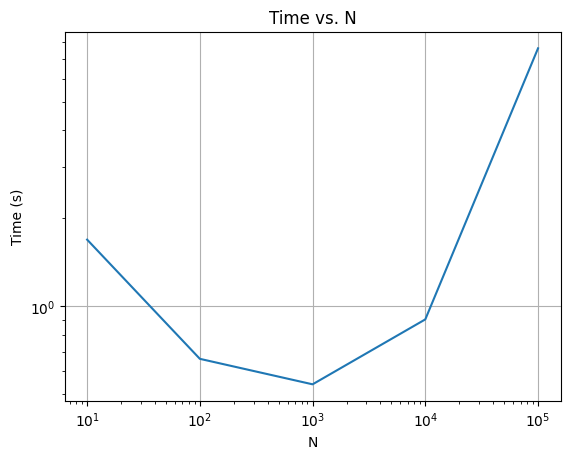

In [ ]:
import matplotlib.pyplot as plt
plt.plot(n_array, times_array)
plt.xlabel('N')
plt.ylabel('Time (s)')
plt.title('Time vs. N')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()